In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import spacy
from collections import Counter
from xgboost import XGBClassifier


nltk.download('stopwords')


spacy.cli.download("fr_core_news_sm")


nlp = spacy.load('fr_core_news_sm')


file_path = 'projetintegrer.csv'  # Update the path if necessary
data = pd.read_csv(file_path)


stop_words = set(stopwords.words('french'))

# clean text
def clean_text(tokens):
    # Remove punctuation and special characters
    tokens = [re.sub(r'\W+', '', token) for token in tokens]
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize using spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]
    return tokens

# Apply cleaning function 
data['Cleaned_Tokens'] = data['Tokenized'].apply(lambda x: clean_text(eval(x)))

# Flatten the list of tokens to create a single list of all words
all_words = [word for tokens in data['Cleaned_Tokens'] for word in tokens]

# Calculate the frequency of each word
word_freq = Counter(all_words)

# Define a threshold for rare words (e.g., words that appear less than 5 times)
threshold = 5

# Create a set of rare words
rare_words = {word for word, freq in word_freq.items() if freq < threshold}

# Function to remove rare words from tokenized text
def remove_rare_words(tokens):
    return [token for token in tokens if token not in rare_words]

# Apply the function to remove rare words
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(remove_rare_words)
data['Cleaned_Text'] = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))

# Generate dummy sentiment labels for demonstration (replace with actual labels if available)
import numpy as np
np.random.seed(42)
data['Sentiment'] = np.random.choice([0, 1], size=len(data))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Cleaned_Text'], data['Sentiment'], test_size=0.2, random_state=42)

# Adjusting the TF-IDF vectorizer parameters
vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 2),  
    max_df=0.95,
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define hyperparameters for Grid Search
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform Grid Search for Naive Bayes
nb_model = MultinomialNB()
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train_tfidf, y_train)
nb_best = grid_search_nb.best_estimator_

# Train and evaluate the best Naive Bayes model
nb_pred = nb_best.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_report = classification_report(y_test, nb_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", nb_report)

# Perform Grid Search for Random Forest
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train)
rf_best = grid_search_rf.best_estimator_

# Train and evaluate the best Random Forest model
rf_pred = rf_best.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

# Perform Grid Search for XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train_tfidf, y_train)
xgb_best = grid_search_xgb.best_estimator_

# Train and evaluate the best XGBoost model
xgb_pred = xgb_best.predict(X_test_tfidf)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_report = classification_report(y_test, xgb_pred)

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Classification Report:\n", xgb_report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Naive Bayes Accuracy: 0.4523809523809524
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.51      0.46       173
           1       0.49      0.40      0.44       205

    accuracy                           0.45       378
   macro avg       0.46      0.46      0.45       378
weighted avg       0.46      0.45      0.45       378

Random Forest Accuracy: 0.4973544973544973
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.77      0.58       173
           1       0.58      0.27      0.37       205

    accuracy  

In [3]:
!pip install smote
!pip install imbalanced-learn
!pip install GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

ERROR: Could not find a version that satisfies the requirement GridSearchCV (from versions: none)
ERROR: No matching distribution found for GridSearchCV


In [4]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

#naive bayes
nb_model = MultinomialNB()
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train_resampled, y_train_resampled)
nb_best = grid_search_nb.best_estimator_

#train the model
nb_pred = nb_best.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_report = classification_report(y_test, nb_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", nb_report)

#random Forest
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_resampled, y_train_resampled)
rf_best = grid_search_rf.best_estimator_

#train RF
rf_pred = rf_best.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

#XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train_resampled, y_train_resampled)
xgb_best = grid_search_xgb.best_estimator_

#train and evaluate the best XGBoost model
xgb_pred = xgb_best.predict(X_test_tfidf)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_report = classification_report(y_test, xgb_pred)

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Classification Report:\n", xgb_report)

Naive Bayes Accuracy: 0.4603174603174603
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.48      0.45       173
           1       0.50      0.44      0.47       205

    accuracy                           0.46       378
   macro avg       0.46      0.46      0.46       378
weighted avg       0.47      0.46      0.46       378

Random Forest Accuracy: 0.5105820105820106
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.50      0.48       173
           1       0.55      0.52      0.54       205

    accuracy                           0.51       378
   macro avg       0.51      0.51      0.51       378
weighted avg       0.51      0.51      0.51       378

XGBoost Accuracy: 0.4894179894179894
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.27      0.33       173
          

In [5]:
print(data.columns)

Index(['Text', 'Tokenized', 'Cleaned_Tokens', 'Cleaned_Text', 'Sentiment'], dtype='object')


In [6]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE

file_path = 'projetintegrer.csv'
data = pd.read_csv(file_path)


analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.7:
        return 3 #++++positive
    elif score['compound'] > 0.1:
        return 2 #positive
    elif score['compound'] > -0.1:
        return 1 #neutral
    elif score['compound'] > -0.7:
        return 0 #neg
    else:
        return 4 #++++++++++++neg
    
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_vader(' '.join(eval(x))))

data.to_csv('zouhirdata.csv', index=False)

print(data.head())


                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  Sentiment  
0                           ['lord', 'god', 'angel']          2  
1  ['blessing', 'hated', 'needle', 'young', 'stro...          3  
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          3  
3                            ['get', 'well', 'soon']          

In [7]:
from textblob import TextBlob

def classify_sentiment_textblob(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity >= 0.7:
        return 3  # Hyper-positive
    elif polarity > 0.1:
        return 2  # Positive
    elif polarity > -0.1:
        return 1  # Neutral
    elif polarity > -0.7:
        return 0  # Negative
    else:
        return 4 #Hyper-negative
    
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_sentiment_textblob(' '.join(eval(x))))

data.to_csv('data.csv', index=False)

print(data.head())


                                                Text  \
0                                    lord god angels   
1  blessings iv hated needles young strong im for...   
2  stage 4 small cell stage 5 3 1 2 years took 16...   
3                                      get well soon   
4                                      get well soon   

                                           Tokenized  \
0                          ['lord', 'god', 'angels']   
1  ['blessings', 'iv', 'hated', 'needles', 'young...   
2  ['stage', 'small', 'cell', 'stage', 'years', '...   
3                            ['get', 'well', 'soon']   
4                            ['get', 'well', 'soon']   

                                      Cleaned_Tokens  Sentiment  
0                           ['lord', 'god', 'angel']          1  
1  ['blessing', 'hated', 'needle', 'young', 'stro...          2  
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          2  
3                            ['get', 'well', 'soon']          

In [8]:
!pip install transformers torch

from transformers import pipeline


classifier = pipeline('sentiment-analysis')


def classify_sentiment_bert(text):
    max_lenght = 512
    truncated_text = text[:max_lenght]
    result = classifier(text)[0]
    label = result['label']
    if label == 'HPos':  
        return 3
    elif label == 'Pos':  
        return 2
    elif label == 'N': 
        return 1
    elif label == 'Neg':  
        return 0
    else:  
        return 4
    
def classify_long_text(text):
    max_lenght = 512
    chunks = [text[i:i + max_lenght] for i in range(0, len(text), max_lenght)]
    sentiments = [classify_sentiment_bert(chunk) for chunk in chunks]
    return max(set(sentiments), key = sentiments.count)

file_path = 'newp.csv'
data = pd.read_csv(file_path)

# Apply sentiment classification
data['Sentiment'] = data['Cleaned_Tokens'].apply(lambda x: classify_long_text(' '.join(eval(x))))

# Save the labeled data to a new CSV file (optional)
data.to_csv('med.csv', index=False)

# Verify the new column
print(data.head())


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


                                      Cleaned_Tokens  Sentiment
0                           ['lord', 'god', 'angel']          4
1  ['blessing', 'hated', 'needle', 'young', 'stro...          4
2  ['stage', 'small', 'cell', 'stage', 'year', 't...          4
3                            ['get', 'well', 'soon']          4
4                            ['get', 'well', 'soon']          4


In [9]:
import pandas as pd

#textblob distribution
file_path = 'data.csv'
data = pd.read_csv(file_path)


sentiment_counts = data['Sentiment'].value_counts().sort_index()

sentiment_proportions = sentiment_counts / len(data)

sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})

print(sentiment_summary)

           Count  Proportion
Sentiment                   
0            104    0.055026
1            612    0.323810
2           1005    0.531746
3            158    0.083598
4             11    0.005820


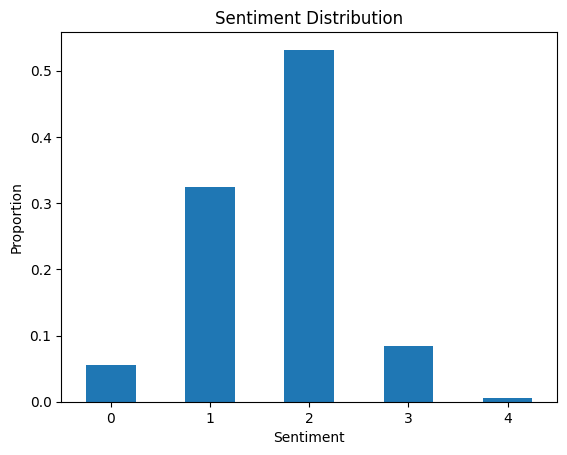

In [22]:
import matplotlib.pyplot as plt

#textblob distribution

sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()


In [10]:
import pandas as pd

#vader distribution
file_path = 'zouhirdata.csv'
data = pd.read_csv(file_path)


sentiment_counts = data['Sentiment'].value_counts().sort_index()

sentiment_proportions = sentiment_counts / len(data)

sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Proportion': sentiment_proportions
})

print(sentiment_summary)

           Count  Proportion
Sentiment                   
0            172    0.091005
1            229    0.121164
2            516    0.273016
3            877    0.464021
4             96    0.050794


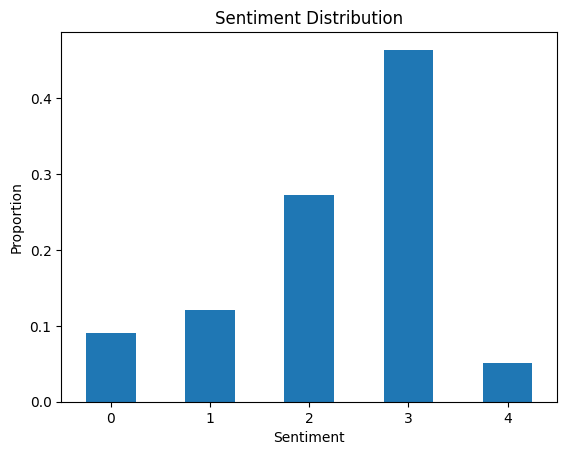

In [24]:
import matplotlib.pyplot as plt

#vader
sentiment_summary.plot(kind='bar', y='Proportion', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()


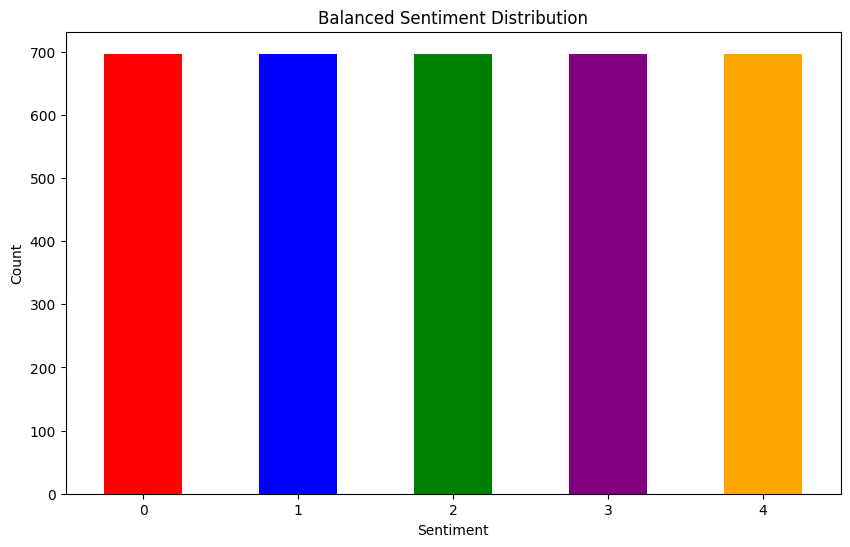

In [11]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

file_path = 'zouhirdata.csv'
data = pd.read_csv(file_path)

data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment']

#Tf-idf
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

#split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# display the distribution
balanced_counts = pd.Series(y_train_balanced).value_counts().sort_index()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
balanced_counts.plot(kind='bar', color=['red', 'blue', 'green', 'purple', 'orange'])
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [12]:
#training the model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)
nb_predictions = nb_model.predict(X_test)

# evaluate the Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.6005291005291006
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.39      0.33        33
           1       0.88      0.40      0.55        53
           2       0.50      0.39      0.44        89
           3       0.76      0.82      0.79       180
           4       0.23      0.43      0.30        23

    accuracy                           0.60       378
   macro avg       0.53      0.49      0.48       378
weighted avg       0.64      0.60      0.60       378



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

#train the model random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_predictions = rf_model.predict(X_test)

#ecaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.6931216931216931
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        33
           1       0.65      0.85      0.74        53
           2       0.60      0.55      0.58        89
           3       0.83      0.82      0.83       180
           4       0.33      0.09      0.14        23

    accuracy                           0.69       378
   macro avg       0.57      0.57      0.55       378
weighted avg       0.69      0.69      0.68       378



In [14]:
from xgboost import XGBClassifier

#train the model
xgb_model = XGBClassifier()
xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_predictions = xgb_model.predict(X_test)

#evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.708994708994709
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        33
           1       0.63      0.83      0.72        53
           2       0.57      0.57      0.57        89
           3       0.86      0.83      0.85       180
           4       0.58      0.30      0.40        23

    accuracy                           0.71       378
   macro avg       0.63      0.61      0.60       378
weighted avg       0.71      0.71      0.71       378



In [15]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train an SVM model
svm_model = SVC()
svm_model.fit(X_train_balanced, y_train_balanced)
svm_predictions = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Accuracy: 0.626984126984127
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        33
           1       0.87      0.25      0.38        53
           2       0.42      0.56      0.48        89
           3       0.73      0.93      0.81       180
           4       0.00      0.00      0.00        23

    accuracy                           0.63       378
   macro avg       0.50      0.39      0.40       378
weighted avg       0.61      0.63      0.58       378



In [8]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load your dataset
file_path = 'zouhirdata.csv'
data = pd.read_csv(file_path)

# Ensure Cleaned_Tokens are in list format
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

# Prepare the data
X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment'] 
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_balanced, y_train_balanced)
logreg_predictions = logreg_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, logreg_predictions)
report = classification_report(y_test, logreg_predictions)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Classification Report:")
print(report)


Logistic Regression Accuracy: 0.6428571428571429
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38        33
           1       0.55      0.70      0.62        53
           2       0.49      0.55      0.52        89
           3       0.87      0.75      0.80       180
           4       0.45      0.39      0.42        23

    accuracy                           0.64       378
   macro avg       0.55      0.56      0.55       378
weighted avg       0.66      0.64      0.65       378



In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

file_path = 'zouhirdata.csv'
data = pd.read_csv(file_path)

#ensure Cleaned_Tokens are in list format
data['Cleaned_Tokens'] = data['Cleaned_Tokens'].apply(eval)

#prepare the data
X = data['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
y = data['Sentiment'] 

#TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train_balanced, y_train_balanced)
gbm_predictions = gbm_model.predict(X_test)

#evaluate the Gradient Boosting model
accuracy = accuracy_score(y_test, gbm_predictions)
report = classification_report(y_test, gbm_predictions)

print("Gradient Boosting Accuracy:", accuracy)
print("Gradient Boosting Classification Report:")
print(report)

Gradient Boosting Accuracy: 0.6534391534391535
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.45      0.42        33
           1       0.50      0.79      0.61        53
           2       0.51      0.43      0.47        89
           3       0.85      0.81      0.83       180
           4       0.58      0.30      0.40        23

    accuracy                           0.65       378
   macro avg       0.57      0.56      0.55       378
weighted avg       0.67      0.65      0.65       378



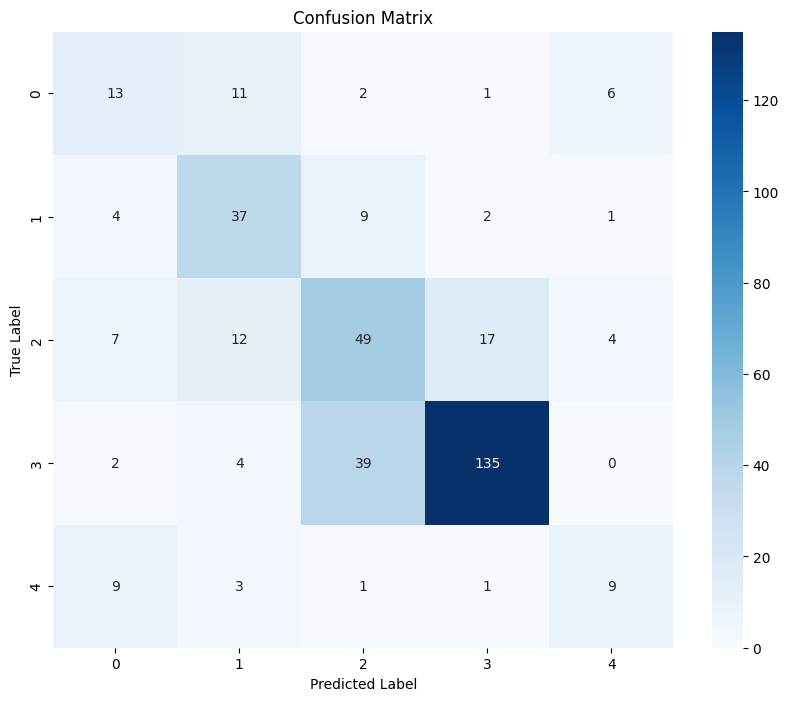

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, logreg_predictions, labels=logreg_model.classes_)

cm_df = pd.DataFrame(cm, index=logreg_model.classes_, columns=logreg_model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
